# Challenge: Validating a linear regression
Validating regression models for prediction
Statistical tests are useful for making sure a model is a good fit to the test data, and that all the features are useful to the model. However, to make sure a model has good predictive validity for new data, it is necessary to assess the performance of the model on new datasets.

The procedure is the same as what you learned in the Naive Bayes lesson – the holdout method and cross-validation method are both available. You've already had experience writing code to run these kinds of validation models for Naive Bayes: now you can try it again with linear regression. In this case, your goal is to achieve a model with a consistent R2 and only statistically significant parameters across multiple samples.

We'll use the property crime model you've been working on with, based on the FBI:UCR data. Since your model formulation to date has used the entire New York State 2013 dataset, you'll need to validate it using some of the other crime datasets available at the FBI:UCR website. Options include other states crime rates in 2013 or crime rates in New York State in other years or a combination of these.

#### Iterate
Based on the results of your validation test, create a revised model, and then test both old and new models on a new holdout or set of folds.

Include your model(s) and a brief writeup of the reasoning behind the validation method you chose and the changes you made to submit and review with your mentor.

In [1]:
import numpy as np
np.set_printoptions(suppress=True)
import pandas as pd
pd.set_option('float_format', '{:.2f}'.format)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
import statsmodels.formula.api as smf
from statsmodels.sandbox.regression.predstd import wls_prediction_std
%matplotlib inline

# Source : https://ucr.fbi.gov/crime-in-the-u.s/2013/crime-in-the-u.s.-2013/tables/table-8/table-8-state-cuts/table_8_offenses_known_to_law_enforcement_new_york_by_city_2013.xls
df = pd.read_csv("./datasets/NY-nKnowOffenses.csv")
df.columns = ['City', 'Population', 'Violent crime', 'Murder and nonnegligent manslaughter', 'Rape (revised definition)', 'Rape (legacy definition)', 'Robbery', 'Aggravated assault', 'PropertyCrime', 'Burglary', 'Larceny theft', 'Motor vehicle theft', 'Arson']
df = df.iloc[4:]
df = df.iloc[:-3]
df

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition),Rape (legacy definition),Robbery,Aggravated assault,PropertyCrime,Burglary,Larceny theft,Motor vehicle theft,Arson
4,Adams Village,"1,861",0,0,NaN,0,0,0,12,2,10,0,0
5,Addison Town and Village,"2,577",3,0,NaN,0,0,3,24,3,20,1,0
6,Akron Village,"2,846",3,0,NaN,0,0,3,16,1,15,0,0
7,Albany,"97,956",791,8,NaN,30,227,526,"4,090",705,"3,243",142,NaN
8,Albion Village,"6,388",23,0,NaN,3,4,16,223,53,165,5,NaN
9,Alfred Village,"4,089",5,0,NaN,0,3,2,46,10,36,0,NaN
10,Allegany Village,"1,781",3,0,NaN,0,0,3,10,0,10,0,0
11,Amherst Town,"118,296",107,1,NaN,7,31,68,"2,118",204,"1,882",32,3
12,Amityville Village,"9,519",9,0,NaN,2,4,3,210,16,188,6,1
13,Amsterdam,"18,182",30,0,NaN,0,12,18,405,99,291,15,0


In [2]:
df['PropertyCrime'] = df['PropertyCrime'].str.replace(',','').astype('int')
df['Robbery'] = df['Robbery'].str.replace(',','').astype('int')
df['Population'] = df['Population'].str.replace(',','').astype('int')
df['Population_2'] = df['Population'].apply(lambda x: x * x)
df['Murder']= df['Murder and nonnegligent manslaughter'].astype('int')
df['Motor_vehicle_theft'] = df['Motor vehicle theft'].str.replace(',','').astype('int')
df['RobberyClass'] = df['Robbery'].apply(lambda x: 1 if int(x) > 0 else 0)
df['MurderClass'] = df['Murder and nonnegligent manslaughter'].apply(lambda x: 1 if int(x) > 0 else 0)
df['Burglary'] = df['Burglary'].str.replace(',','').astype('int')
#Drop the outlier
df = df.drop(df[df.Robbery == 19170].index)
df.describe()

,Population,Robbery,PropertyCrime,Burglary,Population_2,Murder,Motor_vehicle_theft,RobberyClass,MurderClass
count,347.00,347.00,347.00,347.00,347.00,347.00,347.00,347.00,347.00
mean,15956.69,17.87,385.75,72.17,985840709.76,0.61,14.59,0.60,0.14
std,27080.22,94.97,1034.37,264.94,5067232380.43,3.71,67.68,0.49,0.35
min,526.00,0.00,0.00,0.00,276676.00,0.00,0.00,0.00,0.00
25%,2997.00,0.00,40.00,6.00,8982153.00,0.00,0.00,0.00,0.00
50%,7187.00,1.00,112.00,17.00,51652969.00,0.00,2.00,1.00,0.00
75%,18160.50,5.00,340.50,51.00,329804222.50,0.00,7.00,1.00,0.00
max,258789.00,1322.00,12491.00,3458.00,66971746521.00,47.00,957.00,1.00,1.00


                     Population  Robbery  PropertyCrime  Burglary  \
Population                 1.00     0.82           0.89      0.82   
Robbery                    0.82     1.00           0.93      0.96   
PropertyCrime              0.89     0.93           1.00      0.98   
Burglary                   0.82     0.96           0.98      1.00   
Population_2               0.89     0.94           0.89      0.89   
Murder                     0.76     0.96           0.92      0.96   
Motor_vehicle_theft        0.83     0.99           0.95      0.98   
RobberyClass               0.34     0.15           0.27      0.20   
MurderClass                0.50     0.38           0.44      0.40   

                     Population_2  Murder  Motor_vehicle_theft  RobberyClass  \
Population                   0.89    0.76                 0.83          0.34   
Robbery                      0.94    0.96                 0.99          0.15   
PropertyCrime                0.89    0.92                 0.95       

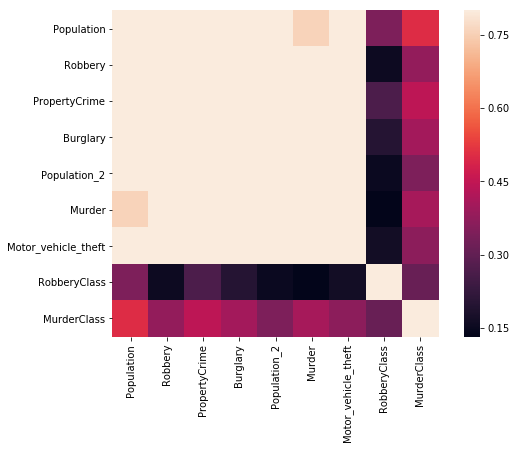

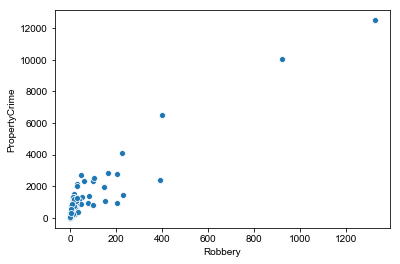

In [3]:
# Make the correlation matrix.
corrmat = df.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(9, 6))

# Draw the heatmap using seaborn.
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

sns.scatterplot(x="Robbery", y="PropertyCrime", data=df)
sns.set(rc={'figure.figsize':(20,8)})
plt.show()

### As given in the task
$$ Property crime = \alpha + Population + Population^2 + Murder + Robbery$$


In [4]:
# Test your model with different holdout groups.
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
Y = df['PropertyCrime']#.values.reshape(-1, 1)
X = df[['RobberyClass','MurderClass', 'Population','Population_2']]
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

df_train = X_train.copy()
df_train['PropertyCrime'] = y_train.copy()

from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm
 
class statsmodel(BaseEstimator, RegressorMixin):
    def __init__(self, sm_class, formula):
        self.sm_class = sm_class
        self.formula = formula
        self.model = None
        self.result = None
 
    def fit(self,data,dummy):
        self.model = self.sm_class(self.formula,data)
        self.result = self.model.fit()
 
    def predict(self,X):
        return self.result.predict(X)
#df_train

In [5]:
linear_formula = 'PropertyCrime ~ RobberyClass+MurderClass+Population+Population_2'

# create a model
clf = statsmodel(smf.ols, linear_formula)
# fit a model
clf.fit(df_train, None)


# Inspect the results.
print('\nParameters: \n', clf.result.params)
print('\np-values: \n', clf.result.pvalues)
print('\nR-squared:')
print(clf.result.rsquared)
print('\nConfidence intervals:')
print(clf.result.conf_int())

y_pred = clf.predict(X_test)
print('\nmean-squared:')
print(mean_squared_error(y_test, y_pred))


Parameters: 
 Intercept      -19.68
RobberyClass    86.74
MurderClass    214.89
Population       0.01
Population_2     0.00
dtype: float64

p-values: 
 Intercept      0.64
RobberyClass   0.15
MurderClass    0.02
Population     0.00
Population_2   0.00
dtype: float64

R-squared:
0.8515876221602994

Confidence intervals:
                   0      1
Intercept    -102.42  63.06
RobberyClass  -32.65 206.13
MurderClass    30.87 398.90
Population      0.01   0.02
Population_2    0.00   0.00

mean-squared:
85466.68248642486


In [6]:
from sklearn.model_selection import cross_val_score
# Print cross val score on this model
print (cross_val_score(clf, df, df['PropertyCrime'], cv=5))

[0.92115442 0.73946592 0.77095115 0.87326866 0.31519852]


#### Own feature engineering and selection
1. To get a better R-squared there was "motor vehicle theft" added, which is a property crime
2. Get rid of population squared, because the coefficient is very very tiny and therefore the feature has almost no impact.

In [7]:
Y = df['PropertyCrime']#.values.reshape(-1, 1)
X = df[['RobberyClass','MurderClass', 'Population','Motor_vehicle_theft']]
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

df_train = X_train.copy()
df_train['PropertyCrime'] = y_train.copy()

linear_formula = 'PropertyCrime ~ RobberyClass+MurderClass+Population+Motor_vehicle_theft'

# create a model
clf = statsmodel(smf.ols, linear_formula)
# fit a model
clf.fit(df_train, None)


# Inspect the results.
print('\nParameters: \n', clf.result.params)
print('\np-values: \n', clf.result.pvalues)
print('\nR-squared:')
print(clf.result.rsquared)
print('\nConfidence intervals:')
print(clf.result.conf_int())

y_pred = clf.predict(X_test)
print('\nmean-squared:')
print(mean_squared_error(y_test, y_pred))

print('\nLess overfitting:')
print('coss-val-score:')
print (cross_val_score(clf, df, df['PropertyCrime'], cv=5))


Parameters: 
 Intercept              -6.70
RobberyClass          111.41
MurderClass           134.49
Population              0.01
Motor_vehicle_theft    11.15
dtype: float64

p-values: 
 Intercept             0.79
RobberyClass          0.00
MurderClass           0.02
Population            0.00
Motor_vehicle_theft   0.00
dtype: float64

R-squared:
0.9424622979780002

Confidence intervals:
                         0      1
Intercept           -57.36  43.96
RobberyClass         39.39 183.42
MurderClass          22.57 246.41
Population            0.01   0.01
Motor_vehicle_theft  10.30  12.00

mean-squared:
51504.34942882877

Less overfitting:
coss-val-score:
[0.93676913 0.75591981 0.44494925 0.94835301 0.82035854]


### With PCA

In [8]:
from sklearn.decomposition import PCA 
# Instantiate and fit our model.
Y = df['PropertyCrime'].copy()#.values.reshape(-1, 1)
X = df[['RobberyClass','MurderClass', 'Population', 'Motor vehicle theft', 'Burglary']].copy()

sklearn_pca = PCA(n_components=3)
X_pca = sklearn_pca.fit_transform(X)
X_pca = pd.DataFrame(data = X_pca
             , columns = ['X', 'V', 'Z'])


# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X_pca, Y, test_size=0.2, random_state=20)

df_train = X_train.copy()
df_train['PropertyCrime'] = y_train.copy()

linear_formula = 'PropertyCrime ~ X+V+Z'

# create a model
clf = statsmodel(smf.ols, linear_formula)
# fit a model
clf.fit(df_train, None)


# Inspect the results.
print('\nParameters: \n', clf.result.params)
print('\np-values: \n', clf.result.pvalues)
print('\nR-squared:')
print(clf.result.rsquared)
print('\nConfidence intervals:')
print(clf.result.conf_int())

y_pred = clf.predict(X_test)
print('\nmean-squared:')
print(mean_squared_error(y_test, y_pred))

print('coss-val-score:')
X_pca['PropertyCrime'] = Y.copy()
print (cross_val_score(clf, X_pca, Y, cv=5))


Parameters: 
 Intercept   381.38
X             0.00
V             0.13
Z            -7.74
dtype: float64

p-values: 
 Intercept   0.00
X           0.46
V           0.80
Z           0.18
dtype: float64

R-squared:
0.011282739752834336

Confidence intervals:
               0      1
Intercept 216.32 546.43
X          -0.00   0.01
V          -0.87   1.13
Z         -19.11   3.64

mean-squared:
258445.20486618308
coss-val-score:
[ 0.02173003  0.36541981 -0.02984344  0.22934975  0.14379423]


#### Conclusion: PCA is not working with this model

## Use the 2014 New York City data set
https://ucr.fbi.gov/crime-in-the-u.s/2014/crime-in-the-u.s.-2014/tables/table-8/table-8-by-state/Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls

In [9]:
df = pd.read_csv("./datasets/New_York_by_City_2014.csv", sep=';', header=None)
df.columns = ['City', 'Population', 'Violent crime', 'Murder and nonnegligent manslaughter', 'Rape (revised definition)', 'Rape (legacy definition)', 'Robbery', 'Aggravated assault', 'PropertyCrime', 'Burglary', 'Larceny theft', 'Motor vehicle theft', 'Arson']
df = df.dropna()
df['PropertyCrime'] = df['PropertyCrime'].str.replace(',','').astype('int')
df['Robbery'] = df['Robbery'].str.replace(',','').astype('int')
df['Population'] = df['Population'].str.replace(',','').astype('int')
df['Population_2'] = df['Population'].apply(lambda x: x * x)
df['Murder']= df['Murder and nonnegligent manslaughter'].astype('int')
df['Motor_vehicle_theft'] = df['Motor vehicle theft'].str.replace(',','').astype('int')
df['RobberyClass'] = df['Robbery'].apply(lambda x: 1 if int(x) > 0 else 0)
df['MurderClass'] = df['Murder and nonnegligent manslaughter'].apply(lambda x: 1 if int(x) > 0 else 0)
df['Burglary'] = df['Burglary'].str.replace(',','').astype('int')
#Drop the outlier
df = df.drop(df[df.Robbery == 19170].index)
df.describe()

,Population,Murder and nonnegligent manslaughter,Rape (legacy definition),Robbery,PropertyCrime,Burglary,Arson,Population_2,Murder,Motor_vehicle_theft,RobberyClass,MurderClass
count,258.00,258.00,258.00,258.00,258.00,258.00,258.00,258.00,258.00,258.00,258.00,258.00
mean,16500.49,0.46,0.00,15.07,365.16,60.49,1.83,984256648.71,0.46,13.17,0.57,0.14
std,26735.01,2.27,0.00,60.80,828.63,180.53,9.44,4196437792.33,2.27,51.96,0.50,0.35
min,79.00,0.00,0.00,0.00,0.00,0.00,0.00,6241.00,0.00,0.00,0.00,0.00
25%,3020.50,0.00,0.00,0.00,32.25,5.00,0.00,9123439.00,0.00,0.00,0.00,0.00
50%,7001.00,0.00,0.00,1.00,104.00,15.00,0.00,49014257.00,0.00,2.00,1.00,0.00
75%,17893.75,0.00,0.00,5.00,348.75,44.00,1.00,320190451.75,0.00,7.00,1.00,0.00
max,210347.00,27.00,0.00,698.00,8856.00,2125.00,135.00,44245860409.00,27.00,673.00,1.00,1.00


In [10]:
Y = df['PropertyCrime']#.values.reshape(-1, 1)
X = df[['RobberyClass','MurderClass', 'Population','Motor_vehicle_theft']]
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)

df_train = X_train.copy()
df_train['PropertyCrime'] = y_train.copy()

linear_formula = 'PropertyCrime ~ RobberyClass+MurderClass+Population+Motor_vehicle_theft'

# create a model
clf = statsmodel(smf.ols, linear_formula)
# fit a model
clf.fit(df_train, None)


# Inspect the results.
print('\nParameters: \n', clf.result.params)
print('\np-values: \n', clf.result.pvalues)
print('\nR-squared:')
print(clf.result.rsquared)
print('\nConfidence intervals:')
print(clf.result.conf_int())

y_pred = clf.predict(X_test)
print('\nmean-squared:')
print(mean_squared_error(y_test, y_pred))

print('coss-val-score:')
print (cross_val_score(clf, df, df['PropertyCrime'], cv=5))


Parameters: 
 Intercept              -1.71
RobberyClass          115.37
MurderClass           318.83
Population              0.01
Motor_vehicle_theft    10.81
dtype: float64

p-values: 
 Intercept             0.96
RobberyClass          0.01
MurderClass           0.00
Population            0.00
Motor_vehicle_theft   0.00
dtype: float64

R-squared:
0.9100355841154706

Confidence intervals:
                         0      1
Intercept           -61.55  58.13
RobberyClass         30.09 200.65
MurderClass         190.85 446.81
Population            0.00   0.01
Motor_vehicle_theft   9.71  11.91

mean-squared:
35626.079421559625
coss-val-score:
[0.81892364 0.77164962 0.79847243 0.95424316 0.78635324]


#### The model is generalizing to the new data of 2014 quite well